In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

from joblib import dump, load
import pickle

def Graph_Confusion_Matrix(CM, labels, title = 'Confusion Matrix'):
    #np.fill_diagonal(CM,0)

    plt.figure(figsize = (4,4))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(CM, annot=True,annot_kws={"size": 16},  fmt='.1f' # fmt='g'
               ,xticklabels = labels
               ,yticklabels = labels)# font size
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def Normalisation(X):
    #X = X.values
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_norm = (X - X_mean)/X_std
    return(X_norm, X_mean, X_std)
    
def Max_Min_Norm(X):
    #X = X.values
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    X_norm = (X-X_min)/(X_max-X_min)
    return(X_norm, X_min, X_max)

plt.style.use('bmh')

In [2]:
df = pd.read_csv("Data/Train_Data_Aft_FE.csv")
df = df.set_index("URN")
K_mean = load('Parameter_Dictionary/k-means.joblib') 

#Load dictionary that has mean and std for k-means
with open('Parameter_Dictionary/K_means_Dict.pickle', 'rb') as handle:
    Para_Dict = pickle.load(handle)

df.drop(["Mosaic Group Num"],axis=1, inplace=True)


#### These are catergorical variables and for this algorithm they can not be used therefore they are being dropped

In [3]:
columns_to_encode =[
'SEX',
'TITLE',
'TOWN',
'OAC_Group',
'COG_TYPE']

for i, col in enumerate(columns_to_encode):
    df.drop([col+"_Encoded"], axis=1, inplace=True)

## Need to add on the customer segments

In [4]:
df_k_means = df[['Months Between DateCr and Last Ask',
'AGE',
#'Mosaic Group Num',
'SEXC1',
'TOWNC1',
'OAC_GroupC1',
'COG_TYPEC1',
'Mosaic GroupC1',
'Total_C1',
'NUM_TRANS_LST_24',
'DONATED_LST_24',
'WRR_EMERG']].copy()

df_k_means["Recency"] = np.where((df_k_means['NUM_TRANS_LST_24']>0),1,0)

X_k_means = (df_k_means.values - Para_Dict.get("K_mean_mean"))/Para_Dict.get("K_mean_std")

In [5]:
df = pd.concat([df,pd.get_dummies(pd.Series(K_mean.predict(X_k_means), index=df.index))],axis=1)

df.drop(['Months Between DateCr and Last Ask',
'AGE',
'SEXC1',
'TOWNC1',
'OAC_GroupC1',
'COG_TYPEC1',
'Mosaic GroupC1',
'Total_C1',
'Total_C0',
'NUM_TRANS_LST_24',
'DONATED_LST_24'], axis=1, inplace=True)

In [6]:
Num_DV_1 = len(df.loc[df["DV"] == 1])

df_final = pd.concat([df.loc[df["DV"] == 1], df.loc[df["DV"] == 0].sample(Num_DV_1, random_state=32)]).copy()
df_final = df_final.sample(frac=1, random_state=53)#.reset_index(drop=True)

In [7]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19036 entries, 87358 to 28144
Data columns (total 29 columns):
DV                                    19036 non-null int64
INCOME                                9518 non-null float64
APPEAL_AVG_GIFT                       19036 non-null float64
EMERG_AVG_GIFT                        19036 non-null float64
EMAIL_FLAG                            19036 non-null int64
NUM_ACTIVE_COG                        19036 non-null int64
NUM_ATTRITED_COG                      19036 non-null int64
NUM_DIFF_COG                          19036 non-null int64
TOTAL_YEARLY_CHARGE                   19036 non-null float64
TOTAL_NUM_MONTH_PAID                  19036 non-null int64
DM_PREVIOUS_12_MONTHS                 19036 non-null int64
NUM_TRANS_LST_24                      19036 non-null int64
DONATED_LST_24                        19036 non-null float64
Months Between DateCr and Last Ask    19036 non-null float64
AGE                                   19036 non-nu

In [8]:
y = df_final["DV"].copy()
X = df_final.drop(["DV","INCOME"],axis=1).copy()

In [9]:
X_norm, X_mean, X_std = Normalisation(X.values)

#Makes it back into a dataframe far more easily readable
X_norm_df = pd.DataFrame(X_norm, columns=X.columns)

In [10]:
from sklearn.svm import SVC

In [12]:
# Load in the best features found from RFE in logistic regression
Features_Ranked = pd.read_csv("Data/RFE_Rank.csv", index_col=0)
Features_Ranked.head(5)
Best_Features = X_norm_df[Features_Ranked.head(10).index].columns

#tuned_parameters = [{ "degree": [3,5],
#                      "C" : [0.1,1,10],
#                      "coef0": [1],
#                    }]

tuned_parameters = [{ "gamma": [0.1, 1, 10],
                      "C" : [0.1,1,10],
                       }]


clf = GridSearchCV(SVC(kernel= "rbf" ), tuned_parameters,   cv=5, scoring = 'accuracy', verbose=5)
clf.fit(X_norm_df[Features_Ranked.head(10).index], y)
print(clf.best_params_)

In [12]:
Best_Features = X_norm_df[Features_Ranked.head(10).index].columns

Model = SVC(kernel = 'rbf', gamma= 0.1 ,C = 10, probability=True)
Acc_Train = []
Acc = []
Recall = []
Precision = []

labels=[1,0]

folds = KFold(n_splits=10, shuffle=False)#, random_state=42)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_norm_df, y)):    
    
    print("Kfold: ",fold_)
    
    Model.fit(X_norm_df.iloc[trn_idx][Best_Features], y.iloc[trn_idx])

    y_pred_prob = Model.predict_proba(X_norm_df.iloc[val_idx][Best_Features])[:,1]
    
    y_pred = y_pred_prob >= 0.5
    
    #CM = confusion_matrix(y.iloc[val_idx].values, y_pred, labels)
    #Graph_Confusion_Matrix(CM, labels)
    
    Y_actual = y.iloc[val_idx]
    
    Acc_Train.append(accuracy_score(y.iloc[trn_idx], Model.predict(X_norm_df.iloc[trn_idx][Best_Features]) >=0.5 )*100)
    
    Acc.append(accuracy_score(Y_actual, y_pred)*100)
    Recall.append(recall_score(Y_actual, y_pred)*100)
    Precision.append(precision_score(Y_actual, y_pred)*100)

    #print("Accuary:", accuracy_score(Y_actual, y_pred)*100)
    #print("Recall:", recall_score(Y_actual, y_pred)*100)
    #print("Precision:", precision_score(Y_actual, y_pred)*100)
    
    if fold_ == 0:
        Outcome_df = pd.concat([df_final[["DV","INCOME"]].loc[X.iloc[val_idx].index], 
           pd.DataFrame(y_pred_prob, index=X.iloc[val_idx].index)],axis=1)
    else:
        Outcome_df = Outcome_df.append(pd.concat([df_final[["DV","INCOME"]].loc[X.iloc[val_idx].index], 
           pd.DataFrame(y_pred_prob, index=X.iloc[val_idx].index)],axis=1), sort=False)
        
Outcome_df.rename(index=str, columns={0:"Score"}, inplace=True)

print("Avg Accuracy Train Set:", np.mean(Acc_Train))
print("Avg Accuracy Test Set:",np.mean(Acc))
print("")
print("Avg Recall:",np.mean(Recall))
print("Avg Precision:",np.mean(Precision))

Outcome_df.to_csv("Model Outputs/SVC.csv", index=True)

Kfold:  0
Kfold:  1
Kfold:  2
Kfold:  3
Kfold:  4
Kfold:  5
Kfold:  6
Kfold:  7
Kfold:  8
Kfold:  9
Avg Accuracy Train Set: 79.07006792350228
Avg Accuracy Test Set: 76.71790339887926

Avg Recall: 75.1040144662854
Avg Precision: 77.6503296047924


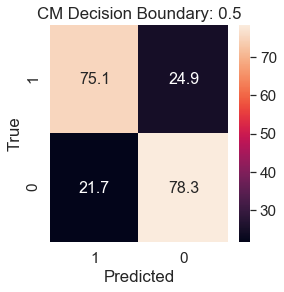

Accuracy: 76.77032990123975
Recall: 74.77411220844715
Precision: 77.88356314291967


In [13]:
Boundry = 0.5

CM = confusion_matrix(Outcome_df["DV"], Outcome_df["Score"]>=Boundry, labels)

#Normalise so is a percentage
CM = np.divide(CM,np.sum(CM, axis=1).reshape(2,-1)) * 100

Graph_Confusion_Matrix(CM, labels, 'CM Decision Boundary: '+str(Boundry))
#plt.savefig("SVC Confusion Matrix/CM_D_B_"+str(Boundry)+".jpg")
plt.show()

print("Accuracy:", accuracy_score(Outcome_df["DV"], Outcome_df["Score"]>Boundry)*100)
print("Recall:", recall_score(Outcome_df["DV"], Outcome_df["Score"]>Boundry)*100)
print("Precision:", precision_score(Outcome_df["DV"], Outcome_df["Score"]>Boundry)*100)

In [14]:
fpr, tpr, _ = roc_curve(Outcome_df["DV"], Outcome_df["Score"])
roc_auc = auc(fpr, tpr)

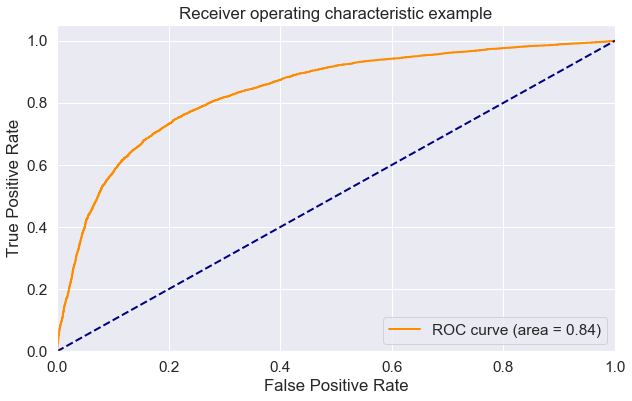

In [15]:
plt.figure(figsize=(10,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [16]:
Outcome_df["Score Band"] = Outcome_df["Score"].astype(str).str.slice(0,3)

### I am now going to do the same to this dataset and add on the customer segments

In [17]:
df_Val = pd.read_csv("Data/Test_Data_Val_Aft_FE.csv")
df_Val = df_Val.set_index("URN")

df_Val.drop(["Mosaic Group Num"],axis=1, inplace=True)

In [18]:
columns_to_encode =[
'SEX',
'TITLE',
'TOWN',
'OAC_Group',
'COG_TYPE']

for i, col in enumerate(columns_to_encode):
    df_Val.drop([col+"_Encoded"], axis=1, inplace=True)

In [19]:
df_k_means_val = df_Val[['Months Between DateCr and Last Ask',
'AGE',
#'Mosaic Group Num',
'SEXC1',
'TOWNC1',
'OAC_GroupC1',
'COG_TYPEC1',
'Mosaic GroupC1',
'Total_C1',
'NUM_TRANS_LST_24',
'DONATED_LST_24',
'WRR_EMERG']].copy()

df_k_means_val["Recency"] = np.where((df_k_means_val['NUM_TRANS_LST_24']>0),1,0)

X_k_means_val = (df_k_means_val.values - Para_Dict.get("K_mean_mean"))/Para_Dict.get("K_mean_std")

In [20]:
df_Val = pd.concat([df_Val,pd.get_dummies(pd.Series(K_mean.predict(X_k_means_val), index=df_Val.index))],axis=1)

X_val_norm = (df_Val.drop(["DV","INCOME"],axis=1).values - X_mean)/X_std

#Makes it back into a dataframe far more easily readable
X_norm_val_df = pd.DataFrame(X_val_norm, columns=X.columns)

## Need to use all of the data to build the model

In [14]:
Model = SVC(kernel = 'rbf'
            ,gamma= 0.1 
            ,C = 10
            , probability=True)

Model.fit(X_norm_df[Best_Features], y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Save the model to disk

In [15]:
dump(Model, 'Parameter_Dictionary/SVC_rbf.joblib') 

['Parameter_Dictionary/SVC_rbf.joblib']

#### Let check the net profit and response rate for the unbalanced dataset

In [21]:
Results_Val = df_Val[["DV", "INCOME"]].copy()
Results_Val["Score"] =  Model.predict_proba(X_norm_val_df[Best_Features].values)[:,1]
Results_Val["Score Band"] = Results_Val["Score"].astype(str).str.slice(0,3)

Results_Val.to_csv("Model Outputs/SVC_UB_VAL.csv", index=True)

In [22]:
Results_Val_2 = Results_Val.groupby(["Score Band"])["INCOME"].agg(["count", "sum", "mean","median","std" ,"max"])
Results_Val_2 = pd.concat([Results_Val["Score Band"].value_counts().sort_index(), Results_Val_2],axis=1).rename(index=str
                                                                                                                 ,columns={"count":"Donors"
                                                                                                                           ,"Score Band": "Contacted Volume"
                                                                                                                           ,"sum": "Total Value"
                                                                                                                           ,"mean": "Mean Gift"
                                                                                                                           ,"median": "Median Gift"
                                                                                                                           ,"max":"Max Gift"})



In [23]:
Results_Val_2["Cost"]= Results_Val_2["Contacted Volume"] * 2.50
Results_Val_2["Net Profit"] = Results_Val_2["Total Value"] - Results_Val_2["Cost"]
Results_Val_2["RR"] = (Results_Val_2["Donors"]/Results_Val_2["Contacted Volume"])
Results_Val_2

,Contacted Volume,Donors,Total Value,Mean Gift,Median Gift,std,Max Gift,Cost,Net Profit,RR
Score Band,,,,,,,,,,
0.0,280,6,420.00,70.000000,75.0,33.466401,100.0,700.0,-280.00,0.021429
0.1,3286,70,2315.00,33.071429,20.0,27.017075,100.0,8215.0,-5900.00,0.021302
0.2,4332,148,7298.00,49.310811,30.0,95.038113,1000.0,10830.0,-3532.00,0.034164
0.3,1079,61,2413.00,39.557377,30.0,35.222400,200.0,2697.5,-284.50,0.056534
0.4,656,52,2799.81,53.842500,30.0,136.338496,1000.0,1640.0,1159.81,0.079268
0.5,520,56,2471.00,44.125000,30.0,36.560815,200.0,1300.0,1171.00,0.107692
0.6,835,96,4237.00,44.135417,30.0,47.149621,300.0,2087.5,2149.50,0.114970
0.7,996,170,8995.00,52.911765,30.0,85.299045,1000.0,2490.0,6505.00,0.170683
0.8,1221,483,24802.00,51.349896,30.0,63.680900,520.0,3052.5,21749.50,0.395577


,Contacted Volume,Donors,Total Value,Mean Gift,Median Gift,std,Max Gift,Cost,Net Profit,RR
Score Band,,,,,,,,,,
0.0,263,5,390.00,78.000000,100.0,30.331502,100.0,789,-399.00,1.901141
0.1,3274,72,2890.00,40.138889,27.5,61.546800,500.0,9822,-6932.00,2.199145
0.2,4294,149,6968.00,46.765101,30.0,87.197383,1000.0,12882,-5914.00,3.469958
0.3,1139,58,2173.00,37.465517,30.0,34.124753,200.0,3417,-1244.00,5.092186
0.4,695,57,3174.81,55.698421,30.0,131.992920,1000.0,2085,1089.81,8.201439
0.5,707,70,2823.00,40.328571,30.0,35.339645,200.0,2121,702.00,9.900990
0.6,646,83,3510.00,42.289157,30.0,43.828249,300.0,1938,1572.00,12.848297
0.7,902,150,8914.00,59.426667,30.0,92.643674,1000.0,2706,6208.00,16.629712
0.8,1273,489,25758.00,52.674847,30.0,68.554144,520.0,3819,21939.00,38.413197


We now want to create a gains and lift chart for the net profit

In [ ]:
Gains_df = Results_Val_2[["Contacted Volume","Cost", "Total Value"]].copy()

In [ ]:
#Sort the index
Gains_df = Gains_df.sort_index(ascending=False)

Gains_df["Random Contacted"] = Gains_df["Contacted Volume"].sum()//10
Gains_df["Random Cost"] = Gains_df["Cost"].sum()/10
Gains_df["Random Total Val"] = Gains_df["Total Value"].sum()/10

#Cumlativbe sum for each column
Gains_df = Gains_df.cumsum()

In [ ]:
Gains_df["Net Profit"] = Gains_df["Total Value"] - Gains_df["Cost"]
Gains_df["Random Net Profit"] = Gains_df["Random Total Val"] - Gains_df["Random Cost"]
Gains_df["% Difference"] = ((Gains_df["Net Profit"] - Gains_df["Random Net Profit"]) / Gains_df["Random Net Profit"])*100


In [ ]:
Gains_df[["Net Profit", "Random Net Profit", "% Difference"]].round(4)

In [ ]:
plt.plot(Gains_df.index, Gains_df["Random Total Val"].values)
plt.plot(Gains_df.index, Gains_df["Total Value"].values)